In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils


from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer, MissingIndicator

from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import precision_score, recall_score, roc_auc_score, confusion_matrix, accuracy_score

In [2]:
oos, df = utils.load()

In [3]:
deal_ids = df[
    [
    "Target Name", "Target Primary Ticker Symbol",
    "Acquiror Name", "Acquiror Primary Ticker Symbol",
    "Date Announced", "Date Effective", "Date Withdrawn"
    ]
]

deal_ids.shape

(1065, 7)

## Preprocessing

In [4]:
def preprocess_data(raw_df):
    df = raw_df.copy()
    df = df.replace([np.inf, -np.inf], np.nan)

    #df = df[SELECTED_FEATURES + ["Success"]]
    
    df = df.drop(columns=[
        "Target Name", "Target Primary Ticker Symbol", "Acquiror Name", 
        "Acquiror Primary Ticker Symbol", "Date Announced", 
        "Date Effective", "Date Withdrawn", "Deal Number",
        ]
    )

    # drop columns which would give data leakage
    cols_to_drop = [
        "Acquiror Closing Price 60 Days After Ann Date ($)",
        "Acquiror Closing Price 90 Days After Ann Date ($)",
        "Acquiror Closing Price 180 Days After Ann Date ($)",
        "Target Closing Price 60 Days After Ann Date ($)",
        "Target Closing Price 90 Days After Ann Date ($)",
        "Target Closing Price 180 Days After Ann Date ($)",
        "Value Based on Effective Date ($mil)",
        "Value Common at Eff. Date ($mil)",
        "Equity Value at Effective Date ($mil)"
    ]

    df = df.drop(columns=cols_to_drop)


    industry_cols = df.columns[df.columns.str.contains("Industry")]
    df = df.drop(columns=industry_cols)

    df["Poison Pill"] = np.where(df["Poison Pill"] == "Yes", 1, 0)
    df["Poison Pill"] = df["Poison Pill"].astype("category")

    return df

In [5]:
processed_df = preprocess_data(df)
display(processed_df.head())
processed_df.shape

,Success,Exchange Ratio,Price Per Share,Acquiror's price per share,Acquiror Closing Price 1 Day After Ann Date ($),Target Share Price 1 Day Prior to Announcement ($),Target Closing Price 1 Day After Ann Date ($),Premium 1 day prior to announce- ment date,Premium 1 week prior to announce- ment date,Premium 4 weeks prior to ann. date,...,Target Common Equity ($mil),Target Earnings Per Share LTM (US$),Target Book Value/sh,Target Capital Expend.,Target Cash & Mktbl,Host Curr. Target Long Term Debt,Target Long-Term Liab.,Target Net Cash Fr. Investing,Target Net Cash fr. Financing,Target Straight Debt
3,0,NaN,35.00,NaN,56.340,24.48,33.48,42.97,62.94,89.39,...,488.664,1.66,0.130623,0.485805,0.942826,-0.075471,-0.066640,1.387961,0.726344,-0.075471
4,1,NaN,16.00,NaN,29.800,10.74,15.91,48.98,46.12,42.60,...,78.272,0.76,0.225649,0.744958,0.126652,NaN,NaN,11.443363,-8.789112,NaN
8,0,NaN,51.00,NaN,174.168,37.74,52.65,35.14,40.50,73.29,...,1075.215,0.62,0.122880,0.261507,0.309831,NaN,5.842139,0.260751,-1.172670,NaN
10,1,0.313,11.77,41.01,40.240,6.90,11.15,70.58,78.60,93.59,...,90.683,-3.39,-0.108329,0.705874,NaN,-0.187518,0.056104,-0.262272,1.052730,-0.187518
12,1,0.120,27.65,47.12,50.280,19.51,27.37,41.74,48.20,60.03,...,919.000,2.16,0.237245,0.512846,-0.311184,0.035656,-0.004973,9.398435,-4.909034,0.035656


(1065, 65)

#### <b> TrainTestSplit + Feature Scaling </b>

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
  processed_df[processed_df.columns.difference(["Success"])], 
  processed_df["Success"],
  random_state = 1,
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((798, 64), (267, 64), (798,), (267,))

In [7]:
numeric_cols = list(X_train.select_dtypes("number").columns)
categorical_cols = list(X_train.select_dtypes("object").columns)
all_cols = list(X_train.columns)

missing_values_transformer = Pipeline(steps = [
  ("na_indicator", MissingIndicator(sparse = False, features = "all"))
])

numeric_transformer = Pipeline(steps=[
  ("imputer", KNNImputer(n_neighbors=2)), ("num", MinMaxScaler())])
  
categorical_transformer = Pipeline(steps=[
  ("imputer'", SimpleImputer(strategy="most_frequent"))])

preprocessor = ColumnTransformer(transformers=[
  ("na_indicator", missing_values_transformer, all_cols),
  ("numeric", numeric_transformer, numeric_cols), 
  ("categorical", categorical_transformer, categorical_cols)
])

In [8]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

X_train_transformed.shape, X_test_transformed.shape

((798, 127), (267, 127))

#### <b> Training step </b>

In [9]:
def compute_metrics(name, clf, x, y_true):
    y_pred = clf.predict(x)

    print(f"----{name} Classifier Performance----")
    print("Accuracy: ", round(accuracy_score(y_true, y_pred), 3))
    print("Precision: ", round(precision_score(y_true, y_pred),3))
    print("Recall: ", round(recall_score(y_true, y_pred),3))
    print("ROC/AUC: ", round(roc_auc_score(y_true, y_pred),3))

    confusion_mat = confusion_matrix(y_true, y_pred, labels=[0,1])
    tn, fp, fn, tp = confusion_mat.ravel()
    
    print("False Positive Rate: ", round((fp)/(fp+tn),3))
    print("Confusion Matrix: ", "\n", confusion_mat)

##### Dummy classifier benchmark:

In [10]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train_transformed, y_train)

compute_metrics("Dummy", dummy_clf, X_test_transformed, y_test)

----Dummy Classifier Performance----
Accuracy:  0.884
Precision:  0.884
Recall:  1.0
ROC/AUC:  0.5
False Positive Rate:  1.0
Confusion Matrix:  
 [[  0  31]
 [  0 236]]


#### Logit

In [11]:
logit = LogisticRegression(penalty="l2")
logit.fit(X_train_transformed, y_train)

compute_metrics("Logit Model", logit, X_test_transformed, y_test)

----Logit Model Classifier Performance----
Accuracy:  0.891
Precision:  0.906
Recall:  0.979
ROC/AUC:  0.602
False Positive Rate:  0.774
Confusion Matrix:  
 [[  7  24]
 [  5 231]]


#### SVM + CV

In [12]:
grid = {
    "C": [1, 10, 50, 100, 1000],
}

gscv = GridSearchCV(SVC(kernel="rbf"), param_grid=grid, scoring="precision", cv=5)
gscv.fit(X_train_transformed, y_train)

best_clf = gscv.best_estimator_
print("Best model params: ", best_clf)

compute_metrics("SVM", best_clf, X_test_transformed, y_test)

Best model params:  SVC(C=10)
----SVM Classifier Performance----
Accuracy:  0.88
Precision:  0.918
Recall:  0.949
ROC/AUC:  0.652
False Positive Rate:  0.645
Confusion Matrix:  
 [[ 11  20]
 [ 12 224]]


#### 1-NN Classifier

In [13]:
knn = KNeighborsClassifier(n_neighbors=1)

knn.fit(X_train_transformed, y_train)

compute_metrics("1-NN", knn, X_test_transformed, y_test)

----1-NN Classifier Performance----
Accuracy:  0.835
Precision:  0.9
Recall:  0.915
ROC/AUC:  0.571
False Positive Rate:  0.774
Confusion Matrix:  
 [[  7  24]
 [ 20 216]]


#### Elbow Graph for KNN

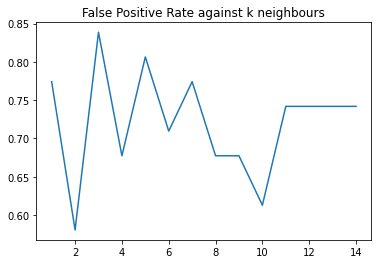

In [14]:
fprs = {}
for k in range(1, 15):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_transformed, y_train)
    y_pred = knn.predict(X_test_transformed)
    
    confusion_mat = confusion_matrix(y_test, y_pred, labels=[0,1])
    tn, fp, fn, tp = confusion_mat.ravel()
    fpr = (fp)/(fp+tn)
    fprs[k] = fpr

pd.Series(fprs).plot(title="False Positive Rate against k neighbours")
plt.show()

#### Random Forest

In [15]:
grid = {
    "base_estimator__n_estimators": [80, 120, 200],
    "base_estimator__max_depth": [3, 11, 15],
}

rf = BaggingClassifier(base_estimator = RandomForestClassifier(random_state = 1))
gscv = GridSearchCV(rf, param_grid=grid, scoring="precision", cv=5)
gscv.fit(X_train_transformed, y_train)

best_clf = gscv.best_estimator_
print("Best model params: ", best_clf)
compute_metrics("RF", best_clf, X_test_transformed, y_test)

Best model params:  BaggingClassifier(base_estimator=RandomForestClassifier(max_depth=15,
                                                        n_estimators=80,
                                                        random_state=1))
----RF Classifier Performance----
Accuracy:  0.895
Precision:  0.894
Recall:  1.0
ROC/AUC:  0.548
False Positive Rate:  0.903
Confusion Matrix:  
 [[  3  28]
 [  0 236]]


#### Decision Tree

In [16]:
grid = {
    "base_estimator__max_depth": [1, 3, 5, 7, 9, 11, 13, 15],
}

dt = BaggingClassifier(base_estimator = DecisionTreeClassifier(random_state = 1))
gscv = GridSearchCV(dt, param_grid=grid, scoring="precision", cv=5)
gscv.fit(X_train_transformed, y_train)

best_clf = gscv.best_estimator_
print("Best model params: ", best_clf)
compute_metrics("DTree", best_clf, X_test_transformed, y_test)

Best model params:  BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=11,
                                                        random_state=1))
----DTree Classifier Performance----
Accuracy:  0.869
Precision:  0.924
Recall:  0.928
ROC/AUC:  0.674
False Positive Rate:  0.581
Confusion Matrix:  
 [[ 13  18]
 [ 17 219]]


#### Model Selection
- Based on above results, we select a majority-voting classifier with SVM + 2-NN + Logit + Decision Tree

In [13]:
# select VotingClassifier with SVM + 2-NN + Logit + dtree
final_clf = VotingClassifier(voting="hard", estimators = [
  ("svm", SVC(kernel = "rbf", probability=True, C=50, random_state = 1)),
  ("knn", KNeighborsClassifier(n_neighbors=2)),
  ("logit", LogisticRegression(penalty="l2")),
  ("dtree", BaggingClassifier(base_estimator = DecisionTreeClassifier(random_state = 1, max_depth=11))),

]
)

final_clf.fit(X_train_transformed, y_train)
compute_metrics("Combined", final_clf, X_test_transformed, y_test)

----Combined Classifier Performance----
Accuracy:  0.854
Precision:  0.923
Recall:  0.911
ROC/AUC:  0.665
False Positive Rate:  0.581
Confusion Matrix:  
 [[ 13  18]
 [ 21 215]]


## True OOS test

In [14]:
processed_oos = preprocess_data(oos)
processed_oos.shape
processed_oos.head()

,Success,Exchange Ratio,Price Per Share,Acquiror's price per share,Acquiror Closing Price 1 Day After Ann Date ($),Target Share Price 1 Day Prior to Announcement ($),Target Closing Price 1 Day After Ann Date ($),Premium 1 day prior to announce- ment date,Premium 1 week prior to announce- ment date,Premium 4 weeks prior to ann. date,...,Target Common Equity ($mil),Target Earnings Per Share LTM (US$),Target Book Value/sh,Target Capital Expend.,Target Cash & Mktbl,Host Curr. Target Long Term Debt,Target Long-Term Liab.,Target Net Cash Fr. Investing,Target Net Cash fr. Financing,Target Straight Debt
2485,1,0.235,10.26,35.15,34.53,6.84,10.00,50.00,54.52,50.44,...,343.454,0.1734,-0.017978,334.356554,-0.022096,0.393508,0.330789,127.928016,-1.094322,0.393508
2487,1,1.000,102.43,52.43,46.89,66.64,84.90,53.71,63.08,40.70,...,6161.000,5.4552,0.018811,0.181999,-0.049920,0.198419,0.170315,1.552323,-0.032605,0.198419
2489,1,NaN,21.00,NaN,38.24,14.24,18.66,47.47,58.01,45.23,...,90.786,0.9095,0.030567,-0.357080,NaN,0.431840,0.022735,-0.354601,-1.805310,0.431840
2492,1,NaN,121.40,NaN,2658.00,121.38,NaN,0.02,2.45,-0.40,...,4.711,6.2273,-2.235348,2.709928,-0.186635,-0.231291,0.033846,2.464939,0.266845,-0.231291
2494,0,NaN,12.00,NaN,NaN,9.75,11.82,23.08,30.01,21.70,...,1035.106,0.1299,0.104179,0.038749,-0.084675,0.110651,-0.160395,-0.182176,-1.057077,-0.127658


In [15]:
oos_X = processed_oos[[col for col in processed_oos.columns if col != "Success"]]
oos_Y = processed_oos["Success"]

oos_X_transformed = preprocessor.transform(oos_X)
oos_X_transformed.shape

(302, 127)

In [16]:
compute_metrics("True OOS Performance", final_clf, oos_X_transformed, oos_Y)
print("")
compute_metrics("Dummy (Always predict true) OOS Performance", dummy_clf, oos_X_transformed, oos_Y)

----True OOS Performance Classifier Performance----
Accuracy:  0.877
Precision:  0.923
Recall:  0.94
ROC/AUC:  0.678
False Positive Rate:  0.583
Confusion Matrix:  
 [[ 15  21]
 [ 16 250]]

----Dummy (Always predict true) OOS Performance Classifier Performance----
Accuracy:  0.881
Precision:  0.881
Recall:  1.0
ROC/AUC:  0.5
False Positive Rate:  1.0
Confusion Matrix:  
 [[  0  36]
 [  0 266]]


#### Map back to original dataframe for backtest

In [17]:
predictions = final_clf.predict(oos_X_transformed)
predictions.shape, oos.shape

((302,), (302, 84))

In [18]:
oos["Predicted"] = predictions
oos.head()

,Success,Date Announced,Date Effective,Date Withdrawn,Deal Number,Target Name,Target Primary Ticker Symbol,Target Industry Sector,Acquiror Name,Acquiror Primary Ticker Symbol,...,Equity Value at Effective Date ($mil),Target Book Value/sh,Target Capital Expend.,Target Cash & Mktbl,Host Curr. Target Long Term Debt,Target Long-Term Liab.,Target Net Cash Fr. Investing,Target Net Cash fr. Financing,Target Straight Debt,Predicted
2485,1,2019-01-02,2019-05-17,NaT,3330497020,MedEquities Realty Trust Inc,MRT,"Investment & Commodity Firms,Dealers,Exchanges",Omega Healthcare Investors Inc,OHI,...,345.545,-0.017978,334.356554,-0.022096,0.393508,0.330789,127.928016,-1.094322,0.393508,1
2487,1,2019-01-03,2019-11-20,NaT,3330372020,Celgene Corp,CELG,Drugs,Bristol-Myers Squibb Co,BMY,...,74557.453,0.018811,0.181999,-0.049920,0.198419,0.170315,1.552323,-0.032605,0.198419,1
2489,1,2019-01-07,2019-07-29,NaT,3331582020,HopFed Bancorp Inc,HFBC,"Savings and Loans, Mutual Savings Banks",First Financial Corp,THFF,...,139.627,0.030567,-0.357080,NaN,0.431840,0.022735,-0.354601,-1.805310,0.431840,1
2492,1,2019-01-08,2019-10-25,NaT,3405759020,Isramco Inc,ISRL,Oil and Gas; Petroleum Refining,Naphtha Israel Petro Corp Ltd,NFTA,...,329.922,-2.235348,2.709928,-0.186635,-0.231291,0.033846,2.464939,0.266845,-0.231291,1
2494,0,2019-01-14,NaT,2019-11-19,3333563020,Gannett Co Inc,GCI,"Printing, Publishing, and Allied Services",MediaNews Group Inc,NaN,...,NaN,0.104179,0.038749,-0.084675,0.110651,-0.160395,-0.182176,-1.057077,-0.127658,0


In [19]:
# filter dataframe for backtest-relevant features
select_columns = [
    "Date Announced",
    "Date Effective",
    "Date Withdrawn",
    "Deal Number",
    "Target Name",
    "Acquiror Name",
    "Exchange Ratio",
    "Price Per Share",
    "Acquiror's price per share",
    "Target Share Price 1 Day Prior to Announcement ($)",
    "Target Closing Price 1 Day After Ann Date ($)",
    "Target Closing Price 60 Days After Ann Date ($)",
    "Target Closing Price 90 Days After Ann Date ($)",
    "Target Closing Price 180 Days After Ann Date ($)",
    "Success",
    "Predicted",
]

backtest_data = oos[select_columns]
backtest_data.head()

,Date Announced,Date Effective,Date Withdrawn,Deal Number,Target Name,Acquiror Name,Exchange Ratio,Price Per Share,Acquiror's price per share,Target Share Price 1 Day Prior to Announcement ($),Target Closing Price 1 Day After Ann Date ($),Target Closing Price 60 Days After Ann Date ($),Target Closing Price 90 Days After Ann Date ($),Target Closing Price 180 Days After Ann Date ($),Success,Predicted
2485,2019-01-02,2019-05-17,NaT,3330497020,MedEquities Realty Trust Inc,Omega Healthcare Investors Inc,0.235,10.26,35.15,6.84,10.00,10.59,11.04,NaN,1,1
2487,2019-01-03,2019-11-20,NaT,3330372020,Celgene Corp,Bristol-Myers Squibb Co,1.000,102.43,52.43,66.64,84.90,85.74,93.85,93.88,1,1
2489,2019-01-07,2019-07-29,NaT,3331582020,HopFed Bancorp Inc,First Financial Corp,NaN,21.00,NaN,14.24,18.66,19.89,19.98,19.68,1,1
2492,2019-01-08,2019-10-25,NaT,3405759020,Isramco Inc,Naphtha Israel Petro Corp Ltd,NaN,121.40,NaN,121.38,NaN,103.01,119.29,123.30,1,1
2494,2019-01-14,NaT,2019-11-19,3333563020,Gannett Co Inc,MediaNews Group Inc,NaN,12.00,NaN,9.75,11.82,10.90,10.10,8.14,0,0


In [20]:
backtest_data.to_pickle("backtest_data.pickle")